In [85]:
from ydata_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [59]:
ends = pd.read_csv("Data/Ends.csv")
games = pd.read_csv("Data/Games.csv")[['CompetitionID','SessionID','GameID','NOC1','NOC2','LSFE','Winner']]
teams = pd.read_csv("Data/Teams.csv")[['CompetitionID','TeamID','Name']]

In [60]:
ends_merged = ends.merge(games, on=['CompetitionID','SessionID','GameID'], how='left')
ends_merged = ends_merged.merge(teams, on=['CompetitionID','TeamID'], how='left')

In [61]:
report = ProfileReport(ends_merged)

In [40]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████| 12/12 [00:00<00:00, 198939.32it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
# Fill missing PowerPlay values and create readable labels
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna('0').astype(str)
ends_merged['PowerPlay_label'] = ends_merged['PowerPlay_clean'].replace({
    '0': 'No PowerPlay', '1.0': 'Right Side', '2.0': 'Left Side'
})

# Sort data by game, team, and end order
ends_merged = ends_merged.sort_values(
    ['CompetitionID','SessionID','GameID','TeamID','EndID']
).reset_index(drop=True)

# PowerPlay (Left/Right) vs Result
## Compare average score and 3+ point chance by PowerPlay side

In [72]:
# Average score per PowerPlay type
pp_avg = (
    ends_merged
    .groupby('PowerPlay_label', as_index=False)['Result']
    .mean()
    .rename(columns={'Result':'AvgResult'})
)

# Probability of scoring 3 or more points
pp_3plus = (
    ends_merged
    .assign(Score3p=(ends_merged['Result']>=3).astype(int))
    .groupby('PowerPlay_label', as_index=False)['Score3p']
    .mean()
    .rename(columns={'Score3p':'P(>=3pts)'})
)

# Combine both tables into one summary
pp_summary = pp_avg.merge(pp_3plus, on='PowerPlay_label')
print("PowerPlay vs Result Summary\n", pp_summary)

PowerPlay vs Result Summary
   PowerPlay_label  AvgResult  P(>=3pts)
0       Left Side   1.568421   0.192982
1    No PowerPlay   0.933276   0.088965
2      Right Side   1.709265   0.226837


# Scoring pattern by end order (1–8)
- The reason there is EndID = 9: If two team's scores are same, extra end is considered.

In [74]:
# Scoring pattern by end order (1–8)
# Average score by EndID (overall and by PowerPlay)

# Overall average score per end
end_curve = (
    ends_merged
    .groupby('EndID', as_index=False)['Result']
    .mean()
    .rename(columns={'Result':'AvgResult'})
)

print("\nAverage score by end (overall)\n", end_curve)

# Average score per end split by PowerPlay label (pivot table)
end_curve_pp = (
    ends_merged
    .pivot_table(index='EndID', columns='PowerPlay_label', values='Result', aggfunc='mean')
    .reset_index()
)
print("\nAverage score by end (by PowerPlay)\n", end_curve_pp)


Average score by end (overall)
    EndID  AvgResult
0      1   0.845930
1      2   0.819767
2      3   0.745640
3      4   0.808140
4      5   0.838663
5      6   0.851744
6      7   1.031773
7      8   2.719917
8      9   0.606061

Average score by end (by PowerPlay)
 PowerPlay_label  EndID  Left Side  No PowerPlay  Right Side
0                    1        NaN      0.845930         NaN
1                    2   0.000000      0.820961         NaN
2                    3   1.250000      0.739970    0.714286
3                    4   0.571429      0.801815    1.384615
4                    5   1.310345      0.751227    1.666667
5                    6   1.447619      0.565217    1.610000
6                    7   1.700000      0.692308    1.644068
7                    8   2.263158      2.752998    2.851852
8                    9        NaN      0.606061         NaN


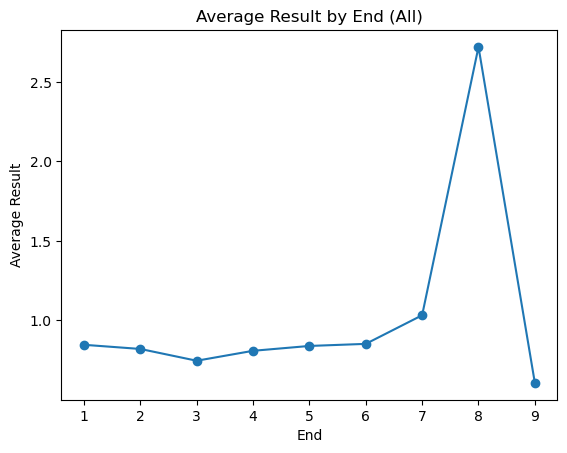

In [79]:
plt.figure()
plt.plot(end_curve['EndID'], end_curve['AvgResult'], marker='o')
plt.title('Average Result by End (All)')
plt.xlabel('End')
plt.ylabel('Average Result')
plt.xticks(range(int(end_curve['EndID'].min()), int(end_curve['EndID'].max())+1))
plt.show()

# Hammer vs Scoring Summary
## Key
LSFE from Games.csv only tells us the first-end hammer.
For later ends, the hammer switches: scoring team gives up the hammer next end;
if the end is blank (0–0), the hammer stays.
Below, we rebuild the hammer holder per end, then compare scoring with/without hammer.


In [89]:
# Merge TeamID1/TeamID2 first to make hammer tracking easier

# Re-merge: include TeamID1/TeamID2 from Games
games_full = pd.read_csv("Data/Games.csv")[['CompetitionID','SessionID','GameID','TeamID1','TeamID2','LSFE','Winner','NOC1','NOC2']]
ends_m = ends.merge(games_full, on=['CompetitionID','SessionID','GameID'], how='left')
ends_m = ends_m.merge(teams, on=['CompetitionID','TeamID'], how='left')  # 팀 이름

# Pivot to wide (rows = game-end, columns = teamID) so we can track hammer per end
wide = (
    ends_m
    .pivot_table(index=['CompetitionID','SessionID','GameID','EndID'],
                 columns='TeamID',
                 values='Result',
                 aggfunc='sum')
)

# Fill missing cells with 0 (a team column might be missing for some rows)
wide = wide.fillna(0)

# Compute hammer flags for a single game (returns a DataFrame with MultiIndex columns)
def compute_hammer_flags(game_df, team1, team2, lsfe):
    """
    game_df: index = [CompetitionID, SessionID, GameID, EndID], columns = [team1, team2] (scores for the game)
    lsfe: 1 means team1 has hammer in end 1; 0 means team2 has hammer in end 1
    Rule: scoring team gives up the hammer next end; a blank end (0-0) keeps the hammer.
    """
    ends_sorted = game_df.sort_index()

    # Promote existing score columns to a MultiIndex: (TeamID, 'Result')
    ends_sorted.columns = pd.MultiIndex.from_product([ends_sorted.columns, ['Result']])

    hammer_t1 = []
    hammer_t2 = []
    h1 = bool(lsfe == 1)   # team1 has the hammer in the first end?
    h2 = not h1

    # Access team scores using ('teamID','Result')
    for _, row in ends_sorted.iterrows():
        hammer_t1.append(int(h1))
        hammer_t2.append(int(h2))
        r1 = row[(team1, 'Result')]
        r2 = row[(team2, 'Result')]

        if (r1 == 0) and (r2 == 0):
            # Blank end: hammer stays
            pass
        elif r1 > r2:
            # team1 scored -> gives up hammer next end
            h1, h2 = False, True
        elif r2 > r1:
            # team2 scored -> gives up hammer next end
            h1, h2 = True, False
        else:
            # Safety guard (unexpected tie case)
            pass

    # Add hammer sub-columns: (teamID, 'Hammer')
    ends_sorted[(team1, 'Hammer')] = hammer_t1
    ends_sorted[(team2, 'Hammer')] = hammer_t2

    # Name the column levels for clean stacking
    ends_sorted.columns.names = ['TeamID', 'Field']
    return ends_sorted

# Loop by game: compute hammer flags, reshape to long, then tidy with pivot
long_rows = []
for (cid, sid, gid), sub in wide.groupby(level=[0,1,2]):
    # Fetch team1/team2 and LSFE for this game
    gm = games_full[
        (games_full['CompetitionID']==cid)&
        (games_full['SessionID']==sid)&
        (games_full['GameID']==gid)
    ].iloc[0]

    t1, t2, lsfe = gm['TeamID1'], gm['TeamID2'], gm['LSFE']

    # Keep only the two team columns for this game (ensure both exist)
    sub2 = sub[[t1, t2]]

    # Compute hammer flags (MultiIndex columns: (TeamID, Field))
    tagged = compute_hammer_flags(sub2, t1, t2, lsfe)

    # Use stack (not melt) to handle MultiIndex columns cleanly
    df_long = (
        tagged
        .stack(['TeamID', 'Field'])        # columns -> row levels (TeamID, Field)
        .reset_index(name='Value')         # final column named 'Value'
    )  # columns: [CompetitionID, SessionID, GameID, EndID, TeamID, Field, Value]

    # Spread 'Result' and 'Hammer' back into columns
    df_long = (
        df_long
        .pivot_table(index=['CompetitionID','SessionID','GameID','EndID','TeamID'],
                     columns='Field', values='Value', aggfunc='first')
        .reset_index()
        .rename_axis(None, axis=1)
    )

    long_rows.append(df_long)

hammer_long = pd.concat(long_rows, ignore_index=True).fillna(0)

# Clean types
hammer_long['Hammer'] = hammer_long['Hammer'].astype(int)      # 0/1
hammer_long['Result'] = hammer_long['Result'].astype(float)    # score

# Binary flag: did the team score (>0)?
hammer_long['Scored'] = (hammer_long['Result'] > 0).astype(int)

# Summary by hammer possession
hammer_summary = (
    hammer_long
    .groupby('Hammer', as_index=False)
    .agg(
        AvgResult = ('Result', 'mean'),
        P_Scored  = ('Scored', 'mean'),
        N         = ('Result', 'size')
    )
    .rename(columns={'Hammer':'HammerFlag'})
)

print("\nHammer vs Scoring Summary\n", hammer_summary)



Hammer vs Scoring Summary
    HammerFlag  AvgResult  P_Scored     N
0           0   0.607129  0.311339  2637
1           1   1.420174  0.709518  2637


# Momentum analysis (scoring flow) in later ends
- Here we look at how scoring changes by end (ΔResult)
- and use average late-end (6–8) scores as a simple momentum indicator.
- Compare team/game scoring trends across early (1–3), mid (4–5), and late (6–8) phases.

In [91]:
# Sort by team and end within each game
g = ends_merged.sort_values(['CompetitionID','SessionID','GameID','TeamID','EndID']).copy()

# Define game phase labels
def end_phase(e):
    if e <= 3: return 'Early(1-3)'
    elif e <= 5: return 'Mid(4-5)'
    else: return 'Late(6-8)'

g['Phase'] = g['EndID'].apply(end_phase)

# Average score by phase (team-game averages aggregated across all games)
phase_avg = (
    g.groupby(['Phase'])['Result']
    .mean()
    .reindex(['Early(1-3)','Mid(4-5)','Late(6-8)'])
    .reset_index(name='AvgResult')
)
print("\nAverage score by phase (early / mid / late)\n", phase_avg)

# End-to-end score change (momentum signal) = current score − previous end score
g['PrevResult'] = g.groupby(['CompetitionID','SessionID','GameID','TeamID'])['Result'].shift(1)
g['DeltaResult'] = g['Result'] - g['PrevResult']

momentum_signal = (
    g.groupby('EndID')['DeltaResult']
    .mean()
    .reset_index(name='AvgDelta')
)
print("\nAverage score change per end (momentum signal)\n", momentum_signal)

# (Optional) Show score trend for one sample game/team
sample = g[
    (g['CompetitionID']==g['CompetitionID'].iloc[0]) &
    (g['SessionID']==g['SessionID'].iloc[0]) &
    (g['GameID']==g['GameID'].iloc[0])
][['TeamID','EndID','Result']]
print("\nSample game score trend by team\n", sample.sort_values(['TeamID','EndID']).head(16))


Average score by phase (early / mid / late)
         Phase  AvgResult
0  Early(1-3)   0.803779
1    Mid(4-5)   0.823401
2   Late(6-8)   1.392585

Average score change per end (momentum signal)
    EndID  AvgDelta
0      1       NaN
1      2 -0.026163
2      3 -0.074128
3      4  0.062500
4      5  0.030523
5      6  0.013081
6      7  0.187291
7      8  1.842324
8      9 -0.121212

Sample game score trend by team
     TeamID  EndID  Result
0       19      1       0
1       19      2       2
2       19      3       0
3       19      4       1
4       19      5       2
5       19      6       0
6       19      7       0
7       19      8       0
8       27      1       1
9       27      2       0
10      27      3       3
11      27      4       0
12      27      5       0
13      27      6       1
14      27      7       3
15      27      8       1


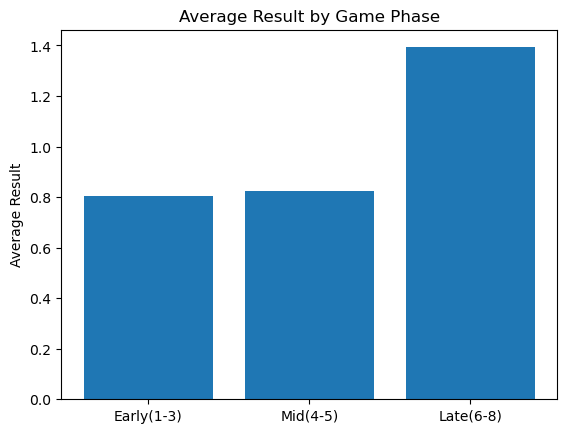

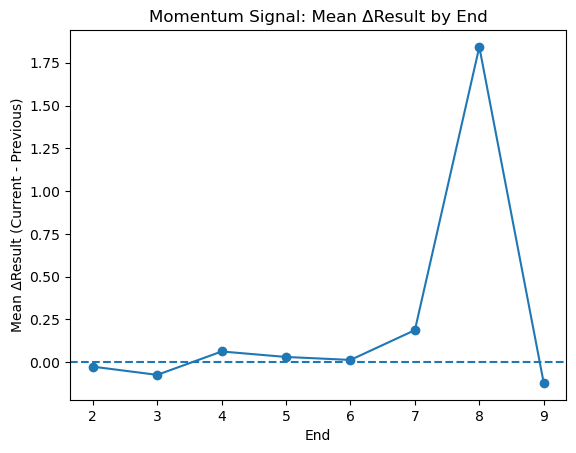

In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(phase_avg['Phase'], phase_avg['AvgResult'])
plt.title('Average Result by Game Phase')
plt.ylabel('Average Result')
plt.show()

plt.figure()
plt.plot(momentum_signal['EndID'], momentum_signal['AvgDelta'], marker='o')
plt.title('Momentum Signal: Mean ΔResult by End')
plt.xlabel('End')
plt.ylabel('Mean ΔResult (Current - Previous)')
plt.axhline(0, linestyle='--')
plt.show()

# PowerPlay usage by End

PowerPlay usage by End
    EndID  Count  UsageRate(%)
0      2      1          0.15
1      3     15          2.18
2      4     27          3.92
3      5     77         11.19
4      6    205         29.80
5      7    208         30.23
6      8     65          9.45


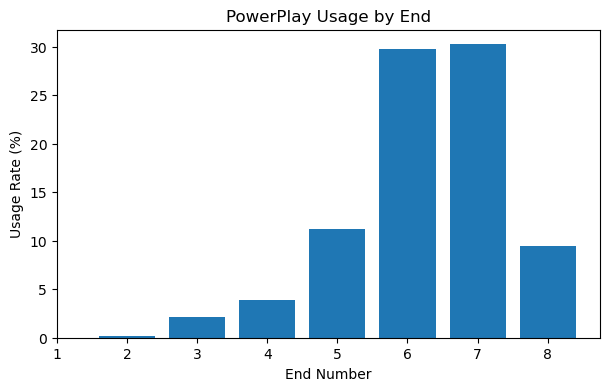

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Clean PowerPlay data
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna(0).astype(int)

# Keep only the ends where PowerPlay was used
pp_used = ends_merged[ends_merged['PowerPlay_clean'] > 0]

# Count how many times PowerPlay was used in each end
pp_by_end = (
    pp_used.groupby('EndID')
    .size()
    .reset_index(name='Count')
)

# Calculate usage rate (%) out of total number of games
total_games = ends_merged[['CompetitionID','SessionID','GameID','TeamID']].drop_duplicates().shape[0]
pp_by_end['UsageRate(%)'] = (pp_by_end['Count'] / total_games * 100).round(2)

print("PowerPlay usage by End\n", pp_by_end)

# Visualize PowerPlay usage frequency by end
plt.figure(figsize=(7,4))
plt.bar(pp_by_end['EndID'], pp_by_end['UsageRate(%)'])
plt.title("PowerPlay Usage by End")
plt.xlabel("End Number")
plt.ylabel("Usage Rate (%)")
plt.xticks(range(1, int(pp_by_end['EndID'].max())+1))
plt.show()


# Teams that never used PowerPlay

In [96]:
# Fill missing PowerPlay values (0 = not used)
ends_merged['PowerPlay_clean'] = ends_merged['PowerPlay'].fillna(0).astype(int)

# For each team, check if they used PowerPlay at least once
pp_usage = (
    ends_merged
    .groupby('TeamID')['PowerPlay_clean']
    .apply(lambda x: (x > 0).any())   # True if any PowerPlay used
    .reset_index(name='UsedPowerPlay')
)

# Merge team names for easier reading
pp_usage = pp_usage.merge(
    teams[['CompetitionID','TeamID','Name']],
    on='TeamID',
    how='left'
).drop_duplicates('TeamID')

# Find teams that never used PowerPlay
no_pp_teams = pp_usage[pp_usage['UsedPowerPlay'] == False]

print("Teams that never used PowerPlay:")
print(no_pp_teams[['TeamID','Name']])
print(f"\nTotal teams that never used PowerPlay: {len(no_pp_teams)}")

Teams that never used PowerPlay:
Empty DataFrame
Columns: [TeamID, Name]
Index: []

Total teams that never used PowerPlay: 0
